# Final Report - Team 2 NLP Project

Ella Xu, Jerry Nolf, Matthew Luna, Nathan Sharick - Innis Cohort

---

### Project Description:

- Most of the code hosting platforms for opensource projects consider the README file as the project introduction. As it is the first document seen by the reader, such a document needs to be crafted with care. The goal of this project is to predict the programming language for 100 repository by scraping, analyze the repository's README file contents. Using these datasets from 100 README's we were able to predict what programming language was used based on the composition of the README text.

### Project Goal:

- The goal of this project was to build a classification model that can predict the programming language of a repository based on the text of the repository's README.md file. 

### Imports

In [1]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
import matt_prepare
import visualization
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


### Data Acquisition, Data Cleaning, and Data Preparation

- Web scraping methods were used to create a list of github username/repositories that included more than 300 repositories. The repositoriy names were pulled from github's top trending repositories, most forked repositories, and most stared repositories as of 05/13/ 2022.

- The list of repositories was put into the acompanying acquire.py file which creates a list of dictionaries that includes the name of the repository, the programming language used in the repository, and the content of the readme file for each repository in the list, and saves it as a .json file. The .json file is required to reproduce this project with this notebook and can be created by saving the acquire.py file in your local repository and running 'python acquire.py' from the terminal.

- Once the .json file is saved in the local directory is can be puled into the notebook, cleaned and prepared using the clean_df function located in the matt_prepare.py file. This function performs the following cleaning/preparation actions:
    - It uses pandas to read the file into the notebook
    
    - It cleans the data by normalizing it, changing all words to lower case, and removing any characters that are not letters, numbers, or whitespace
    
    - It tokenizes the words in the readme content using a toktok tokenizer
    
    - It removes standard english stopwords from the readme content
    
    - It then outputs a dataframe with the following columns:
        - name of the repository
        
        - Programming language of the repository
        
        - The raw readme contents
        
        - The cleaned readme content
        
        - The cleaned readme content that has been stemmed using a PorterStemmer
        
        - The cleaned readme content that has been lemmatized using a WordNetLemmatizer
        
        - The character count for the readme content
        
        - The word count for the readme content
        
- The dataset is then split into train, validate, and test sets using the split_data function located in the matt_prepare.py file which returns a train set with 56%, validate set with 24%, and test set with 20% of the original data frame


In [2]:
#pull in, clean, and prepare the dataset using the clean_df function
df = matt_prepare.clean_df()
#view the first five rows of the returned dataframe
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count,top_five_languages
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...,codeup setup script setup script codeup studen...,codeup setup script setup script codeup studen...,codeup setup script setup script codeup studen...,1062,119,other
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movies application project building single pag...,movi applic project build singl page movi appl...,movie application project building single page...,2888,411,JavaScript
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel several guides kernel developers ...,linux kernel sever guid kernel develop user gu...,linux kernel several guide kernel developer us...,505,58,other
4,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...,introduction second programming assignment req...,introduct second program assign requir write r...,introduction second programming assignment req...,2488,332,other
5,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...,well hello repositori meant provid exampl fork...,well hello repository meant provide example fo...,519,60,other


In [3]:
#split the dataset into train, validate, and test using the split_data function
train, validate, test = matt_prepare.split_data(df)
#view the row and column counts of the split dataframes
train.shape, validate.shape, test.shape

((150, 9), (65, 9), (54, 9))

---

### Data Exploration

- Data exploration comments.....

**Question 1:** What are the most common languages from the repos we explored?

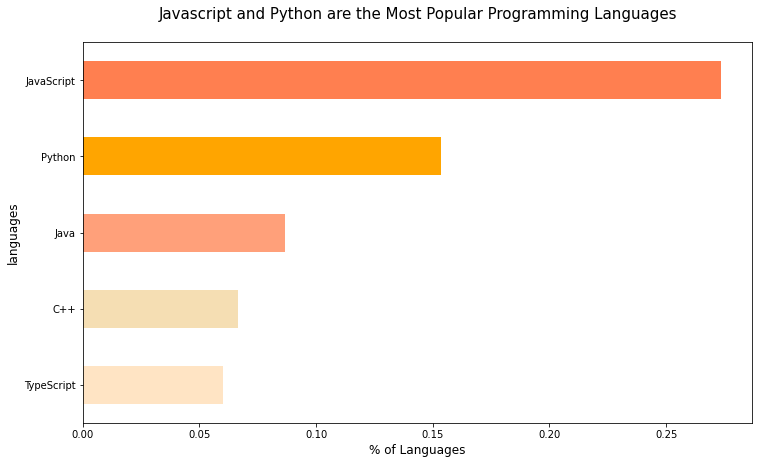

In [4]:
visualization.top_languages(train)

***Takeaways: Javascript and Python are two most frequently used languages.***

**Question 2:** What are the most common words across TOP languages README?

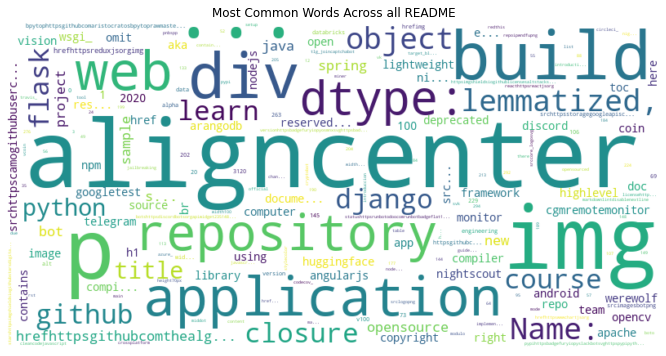

In [5]:
visualization.word_cloud(train)

***Takeaways: There are popular words across top languages readme such as aligncenter, application, build, web, p....***

**Question 3:** Are there any relationship between char count and word count? 

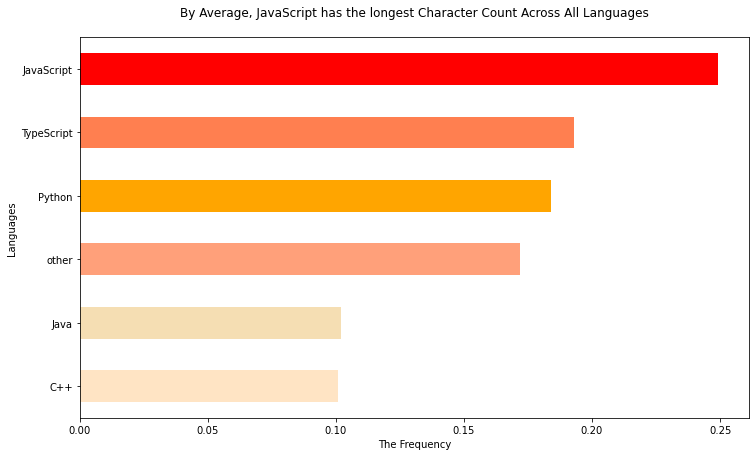

In [6]:
visualization.char_count(train)

#### Statistical Testing (Correlation):


#### Hypothesis:

 - H0: There is no linear relationship between character count and word count of a READme.

 - Ha: There is a linear relationship between character count and word count of a READme.

A Pearson's r statistical test will allow us to

In [7]:
visualization.question3_stats(train)

The findings of the Pearson's r test are as follows:
------------------------------------------------------
r-value = 0.993
p-value = 0.0
With an r-value of 0.993, we reject the null hypthesis
that there is no linear relationship between character
count and word count.


***Takeaways: There is a positive relationship between character count vs word count.*** 

**Question 4:** Does the length of READme differ between languages?

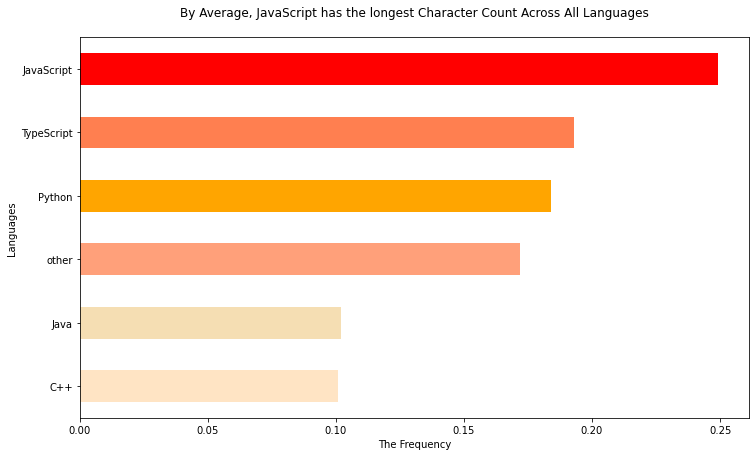

In [8]:
visualization.char_count(train)

***Takeaways: By Average, JavaScript has the longest character count across all languages, follows by TypeScript***

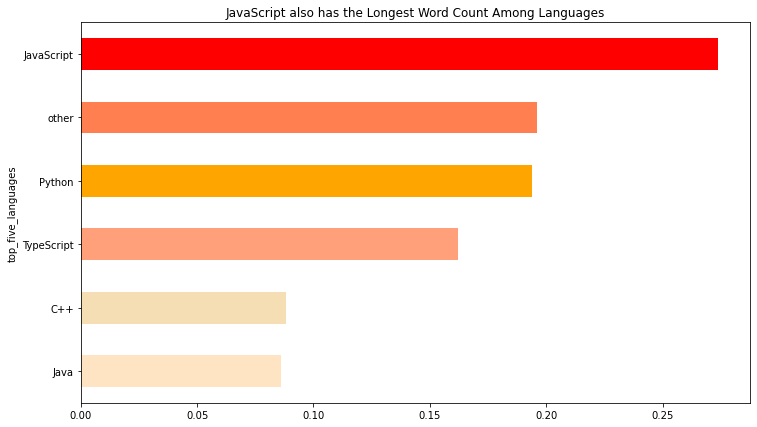

In [9]:
visualization.word_count(train)

***Takeaways: JavaScript has has the longest word count across all languages, follows by other and they python, compare word and character count,python has longer word count, but Typescript has longer character count.***

### Takeaways from Data Exploration

- Takeaway notes......

---

### Data Preparation for Modeling

- Notes on prep for modeling, bag of words, count vectorizer etc.......

In [10]:
X_train = train.lemmatized
y_train = train.top_five_languages
X_val = validate.lemmatized
y_val = validate.top_five_languages
X_test = test.lemmatized
y_test = test.top_five_languages

---

### Modeling

- Notes on modeling.....

In [11]:
#decision tree modeling with unigrams 
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train)
X_bow_val = cv.transform(X_val)

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
X_tfidf_val = tfidf.transform(X_val)

In [12]:
tree = DecisionTreeClassifier(max_depth=15, random_state=123)
tree.fit(X_bow, y_train)
tree.score(X_bow, y_train), tree.score(X_bow_val, y_val)

(0.9666666666666667, 0.6307692307692307)

In [13]:
tree = DecisionTreeClassifier(max_depth=15, random_state=123)
tree.fit(X_tfidf, y_train)
tree.score(X_tfidf, y_train), tree.score(X_tfidf_val, y_val)

(0.98, 0.6)

---

In [14]:
#decision tree modeling with unigrams and bigrams
cv = CountVectorizer(ngram_range=(1,2))
X_bow = cv.fit_transform(X_train)
X_bow_val = cv.transform(X_val)

tfidf = TfidfVectorizer(ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X_train)
X_tfidf_val = tfidf.transform(X_val)

In [15]:
tree = DecisionTreeClassifier(max_depth=20, random_state=123)
tree.fit(X_bow, y_train)
tree.score(X_bow, y_train), tree.score(X_bow_val, y_val)

(0.9933333333333333, 0.5846153846153846)

In [16]:
tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_tfidf, y_train)
tree.score(X_tfidf, y_train), tree.score(X_tfidf_val, y_val)

(0.88, 0.6307692307692307)

---

### Results from Modeling

- Notes on modeling results .....

---

### Summary

- Summary notes .....

### Next Steps

- Notes for next steps ....